

## Author - Deepti Sammeta
## RL Individual Assignment - Text flappy bird    Agents : MCQ learning and Sarsa

In [17]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-dj9h3yay
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-dj9h3yay
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py) ... done


In [ ]:
import os, sys
import gymnasium as gym
import time
import random
import pickle
from collections import defaultdict
import numpy as np
import text_flappy_bird_gym

In [ ]:
if __name__ == '__main__':

    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    obs = env.reset()

    # iterate
    while True:

        # Select next action
        action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)

        # Render the game
        os.system("clear")
        sys.stdout.write(env.render())
        time.sleep(0.2) # FPS

        # If player is dead break
        if done:
            break

    env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[      @             ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=0)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[      @             ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=-1)
Text Flappy Bird!
Score: 0
----------------------
[      

Implemenatation of Montecarlo-Qlearning

In [ ]:
# Montecarlo -q learning
class MonteCarloQAgent:
    def agent_init(self, agent_init_mc):

        # Store the parameters provided in agent_init_mc.
        self.num_actions = agent_init_mc["num_actions"]
        self.num_states = agent_init_mc["num_states"]
        self.epsilon = agent_init_mc['eps_start']
        self.eps_decay = agent_init_mc['eps_decay'] #Amount of decay per episode
        self.eps_min = agent_init_mc['eps_min'] #The maximum amount that epsilon could decay to
        self.step_size = agent_init_mc["step_size"]
        self.discount = agent_init_mc["discount"]
        self.rand_generator = np.random.RandomState(agent_init_mc["seed"])

        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

        self.state_dict = {}
        self.state_action_counts = defaultdict(lambda: np.zeros(self.num_actions))

        self.episode = []

    def agent_start(self, state):

        #Decay epsilon at the start of each episode
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)

        if state not in self.state_dict.keys():
            self.state_dict[state] = len(self.state_dict)
        state_idx = self.state_dict[state]

        # Choose action using epsilon greedy.
        current_q = self.q[state_idx,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection
        self.prev_state_idx = state_idx
        self.prev_action = action
        return action

    def agent_step(self, reward, state):

        if state not in self.state_dict.keys():
            self.state_dict[state] = len(self.state_dict)
        state_idx = self.state_dict[state]

        # state-action
        self.episode.append((self.prev_state_idx, self.prev_action, reward))

        # Choose action using epsilon greedy.
        current_q = self.q[state_idx, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        self.prev_state_idx = state_idx
        self.prev_action = action
        return action

    def agent_end(self, reward):
        # Append the terminal state-action pair to the episode
        self.episode.append((self.prev_state_idx, self.prev_action, reward))

        # Update Q-values based on the entire episode
        G = 0
        for t in reversed(range(len(self.episode))):
            state, action, r = self.episode[t]
            G = self.discount * G + r
            state_action_pair = (state, action)
            if state_action_pair not in self.state_action_counts:
                self.state_action_counts[state_action_pair] = 1
            else:
                self.state_action_counts[state_action_pair] += 1
            alpha = 1 / self.state_action_counts[state_action_pair]
            self.q[state][action] += alpha * (G - self.q[state][action])

        self.episode = []

    def argmax(self, q_values):
        top = float("-inf")
        ties = []
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []
            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

Implementation of sarsa agent

In [ ]:
class SarsaAgent:
    def agent_init(self, agent_init_sarsa):

        # Initaize the agent from agent_init_sarsa.
        self.num_actions = agent_init_sarsa["num_actions"]
        self.num_states = agent_init_sarsa["num_states"]
        self.epsilon = agent_init_sarsa['eps_start']
        self.eps_decay = agent_init_sarsa['eps_decay']
        self.eps_min = agent_init_sarsa['eps_min']
        self.step_size = agent_init_sarsa["step_size"]
        self.discount = agent_init_sarsa["discount"]
        self.rand_generator = np.random.RandomState(agent_init_sarsa["seed"])

        self.q = np.zeros((self.num_states, self.num_actions))
        self.state_dict = {}

    def agent_start(self, state):
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)
        state_idx = self._get_state_index(state)

        current_q = self.q[state_idx, :]
        action = self._epsilon_greedy_policy(current_q)

        self.prev_state_idx = state_idx
        self.prev_action = action
        return action

    def agent_step(self, reward, state):
        state_idx = self._get_state_index(state)

        current_q = self.q[state_idx, :] #current state
        action = self._epsilon_greedy_policy(current_q)
        expected_q = self._expected_q_value(current_q)

        self.q[self.prev_state_idx, self.prev_action] += self.step_size * (
            reward + self.discount * expected_q - self.q[self.prev_state_idx, self.prev_action])

        self.prev_state_idx = state_idx
        self.prev_action = action
        return action

    def agent_end(self, reward):
        self.q[self.prev_state_idx, self.prev_action] += self.step_size * (
            reward - self.q[self.prev_state_idx, self.prev_action])

    def _get_state_index(self, state):
        if state not in self.state_dict:
            self.state_dict[state] = len(self.state_dict)
        return self.state_dict[state]

    def _epsilon_greedy_policy(self, q_values):
        if self.rand_generator.rand() < self.epsilon:
            return self.rand_generator.randint(self.num_actions)
        else:
            return np.argmax(q_values)

    def _expected_q_value(self, q_values):
        q_max = np.max(q_values)
        epsilon_prob = np.ones(self.num_actions) * self.epsilon / self.num_actions
        greedy_prob = (q_values == q_max) * (1 - self.epsilon) / np.sum(q_values == q_max)
        pi = epsilon_prob + greedy_prob
        return np.sum(pi * q_values)

In [ ]:
from tqdm import tqdm

def train_agent(num_episodes, max_score,eps_start, eps_decay, eps_min, step_size, gamma,algorithm = None):

    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

    # get number of states and actions from environment
    n_states = env.observation_space[0].n * env.observation_space[1].n
    n_actions = env.action_space.n

    init_agent = {"num_actions": n_actions,"num_states":n_states,"eps_start":eps_start,"step_size":step_size,
                 "eps_decay": eps_decay,"eps_min": eps_min,"discount": gamma,"seed": 0}

       # checking for the valid algorithm
    if algorithm == 'MCQL':
        agent = MonteCarloQAgent()  # Make sure this class is defined or imported
    elif algorithm == 'SARSA':
        agent = SarsaAgent()  # Make sure this class is defined or imported
    else:
        raise ValueError("Invalid algorithm")


    agent.agent_init(init_agent)

    scores_history = []
    total_reward_history = []
    # Initialize dictionaries to store cumulative rewards for each algorithm
    all_reward_sums = {'Monte Carlo': [], 'SARSA': []}

    for _ in tqdm(range(num_episodes)):
      state = env.reset()
      state = state[0]

      action = agent.agent_start(state)
      reward = 0
      total_reward = 0
      while True:
        action = agent.agent_step(reward, state)
        next_state, reward, done,_, info = env.step(action)
        total_reward += reward
        state = next_state
        if done:
          agent.agent_end(reward)
          scores_history.append(info['score']) #append the score at the end of the episode
          total_reward_history.append(total_reward) #append the cumul reward at the end of the episode
          break

        #Since the agent could theoretically run forever, a max score is added as a second condition to force
        #the agent to die if achieveing the max score
        if info['score'] >= max_score:
          scores_history.append(info['score'])
          total_reward_history.append(total_reward)
          break

    return agent, scores_history,total_reward_history

In [ ]:
# Initialize dictionaries to store cumulative rewards for each algorithm
all_reward_sums = {'Monte Carlo': [], 'SARSA': []}

In [ ]:
num_episodes = 10000
max_score = 1000
eps_start = 0.1
eps_decay = 0.99
eps_min = 0.01
step_size = 0.1
gamma = 0.9
algorithm = 'MCQL'
agent, scores_history, total_reward_history = train_agent(num_episodes, max_score,eps_start, eps_decay, eps_min, step_size, gamma,algorithm)
all_reward_sums['Monte Carlo'] = total_reward_history
print("total_reward_history", sum(total_reward_history))

100%|██████████| 10000/10000 [05:32<00:00, 30.09it/s]

total_reward_history 6379418


In [ ]:
num_episodes = 10000
max_score = 1500
eps_start = 0.8
eps_decay = 0.99
eps_min = 1e-4
step_size = 0.4
gamma = 0.95
algorithm = 'SARSA'
agent_sarsa, scores_history_sarsa, total_reward_history_sarsa = train_agent(num_episodes, max_score,eps_start, eps_decay, eps_min, step_size, gamma,algorithm)
all_reward_sums['SARSA'] = total_reward_history_sarsa
print("Total reward history sarsa", len(total_reward_history_sarsa))

100%|██████████| 10000/10000 [00:23<00:00, 429.55it/s]

Total reward history sarsa 10000


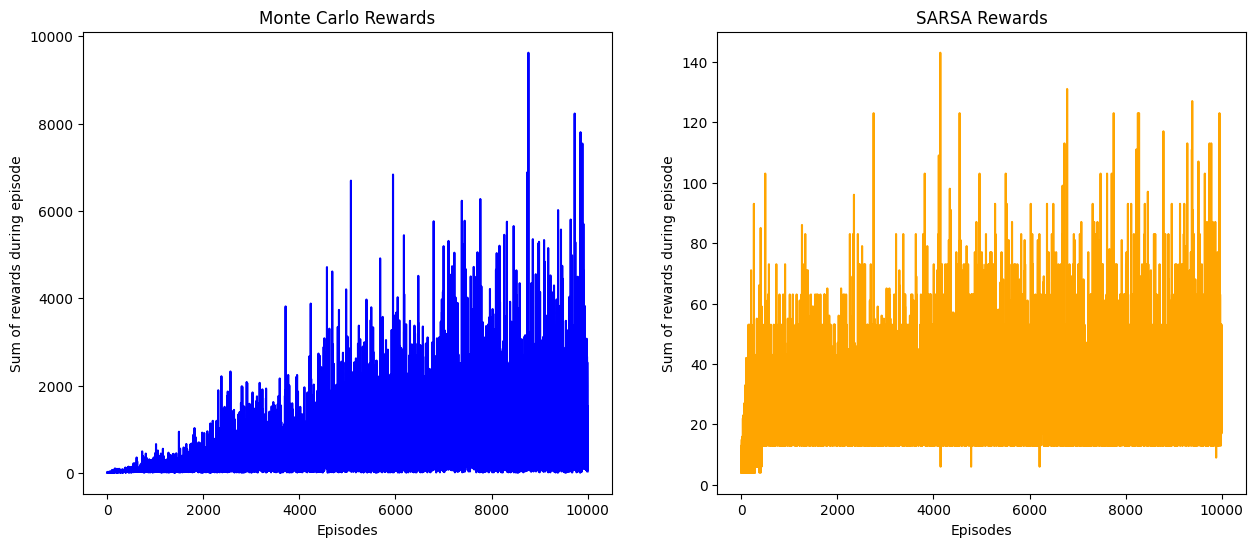

In [ ]:
import matplotlib.pyplot as plt

# Save results for Monte Carlo agent
np.save('monte_carlo.npy', all_reward_sums['Monte Carlo'])

# Save results for SARSA agent
np.save('sarsa.npy', all_reward_sums['SARSA'])

# Load the Monte Carlo and SARSA rewards data from the npy files
monte_carlo_rewards = np.load('monte_carlo.npy')
sarsa_rewards = np.load('sarsa.npy')

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot Monte Carlo rewards
axs[0].plot(monte_carlo_rewards, color='blue')
axs[0].set_title('Monte Carlo Rewards')
axs[0].set_xlabel('Episodes')
axs[0].set_ylabel('Sum of rewards during episode')

# Plot SARSA rewards
axs[1].plot(sarsa_rewards, color='orange')
axs[1].set_title('SARSA Rewards')
axs[1].set_xlabel('Episodes')
axs[1].set_ylabel('Sum of rewards during episode')

plt.show()

Hyperparameter tuning to understand the sensitivity to parameters and convergence to time

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

In [ ]:
def plot_hpt_score(score_history, score_name,agent_name,window=100):
    assert score_name in score_history.keys()
    plt.figure(figsize = (20,10))

    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(score_history[score_name].keys())))))
    for pair in score_history[score_name].keys():
        plt.plot(pd.Series(score_history[score_name][pair]).rolling(500).mean(),
                 label = f"step size:{pair[0]}, epsilon start: {pair[1]}")

    plt.title(f"{agent_name} Hyper Parameter Tuning");
    plt.xlabel('Number of Episodes')
    plt.ylabel(f"Moving Average {score_name}")
    plt.legend()
    plt.show()

In [12]:
#Agent 1 MCQ-Learning Hyperparameter Tuning
params = {"alpha": [0.2, 0.4, 0.8, 1.0], "eps_start": [0.5, 0.8]}
MCQL_scores = {}
MCQL_rewards = {}
total_trials = np.prod(np.array([len(params[key]) for key in params.keys()]))
i = 0
for alpha in params['alpha']:
    for eps_start in params['eps_start']:
        i+=1
        agent, scores_history,total_reward_history = train_agent(num_episodes = 10000,
                                                                             max_score = 1500, eps_start = eps_start,
                                                                             eps_decay = 0.999, eps_min = 1e-4,
                                                                             step_size = alpha,
                                                                             gamma = 0.95,algorithm = 'MCQL')
        MCQL_scores[(alpha,eps_start)] = scores_history
        MCQL_rewards[alpha,eps_start] = total_reward_history
        print(f"{i}/{total_trials} trials completed!")

100%|██████████| 10000/10000 [11:20<00:00, 14.70it/s]


1/8 trials completed!


100%|██████████| 10000/10000 [40:13<00:00,  4.14it/s]


2/8 trials completed!


100%|██████████| 10000/10000 [42:08<00:00,  3.95it/s]


3/8 trials completed!


100%|██████████| 10000/10000 [38:42<00:00,  4.31it/s]


4/8 trials completed!


100%|██████████| 10000/10000 [44:46<00:00,  3.72it/s]


5/8 trials completed!


100%|██████████| 10000/10000 [39:16<00:00,  4.24it/s]


6/8 trials completed!


100%|██████████| 10000/10000 [41:51<00:00,  3.98it/s]


7/8 trials completed!


100%|██████████| 10000/10000 [09:39<00:00, 17.25it/s]

8/8 trials completed!


In [13]:
#Save Hyperparameter Scores
models_path='\content'
f = open(models_path + "MCQL"+"_scores_10000_gs_dict_1500_pipes.pkl","wb")
pickle.dump(MCQL_scores,f)
f.close()

f = open(models_path + "MCQL"+"_rewards_10000_gs_dict_1500_pipes.pkl","wb")
pickle.dump(MCQL_rewards,f)
f.close()

In [14]:
#Load Hyperparameter Scores
with (open(models_path + "MCQL_scores_10000_gs_dict_1500_pipes.pkl", "rb")) as openfile:
    while True:
        try:
           MCQL_scores_10000 =  pickle.load(openfile)
        except EOFError:
            break

with (open(models_path+ "MCQL_rewards_10000_gs_dict_1500_pipes.pkl", "rb")) as openfile:
    while True:
        try:
           MCQL_rewards_10000 =  pickle.load(openfile)
        except EOFError:
            break

In [15]:
MCQL_param_tuning = {"scores":MCQL_scores_10000,"rewards":MCQL_rewards_10000}

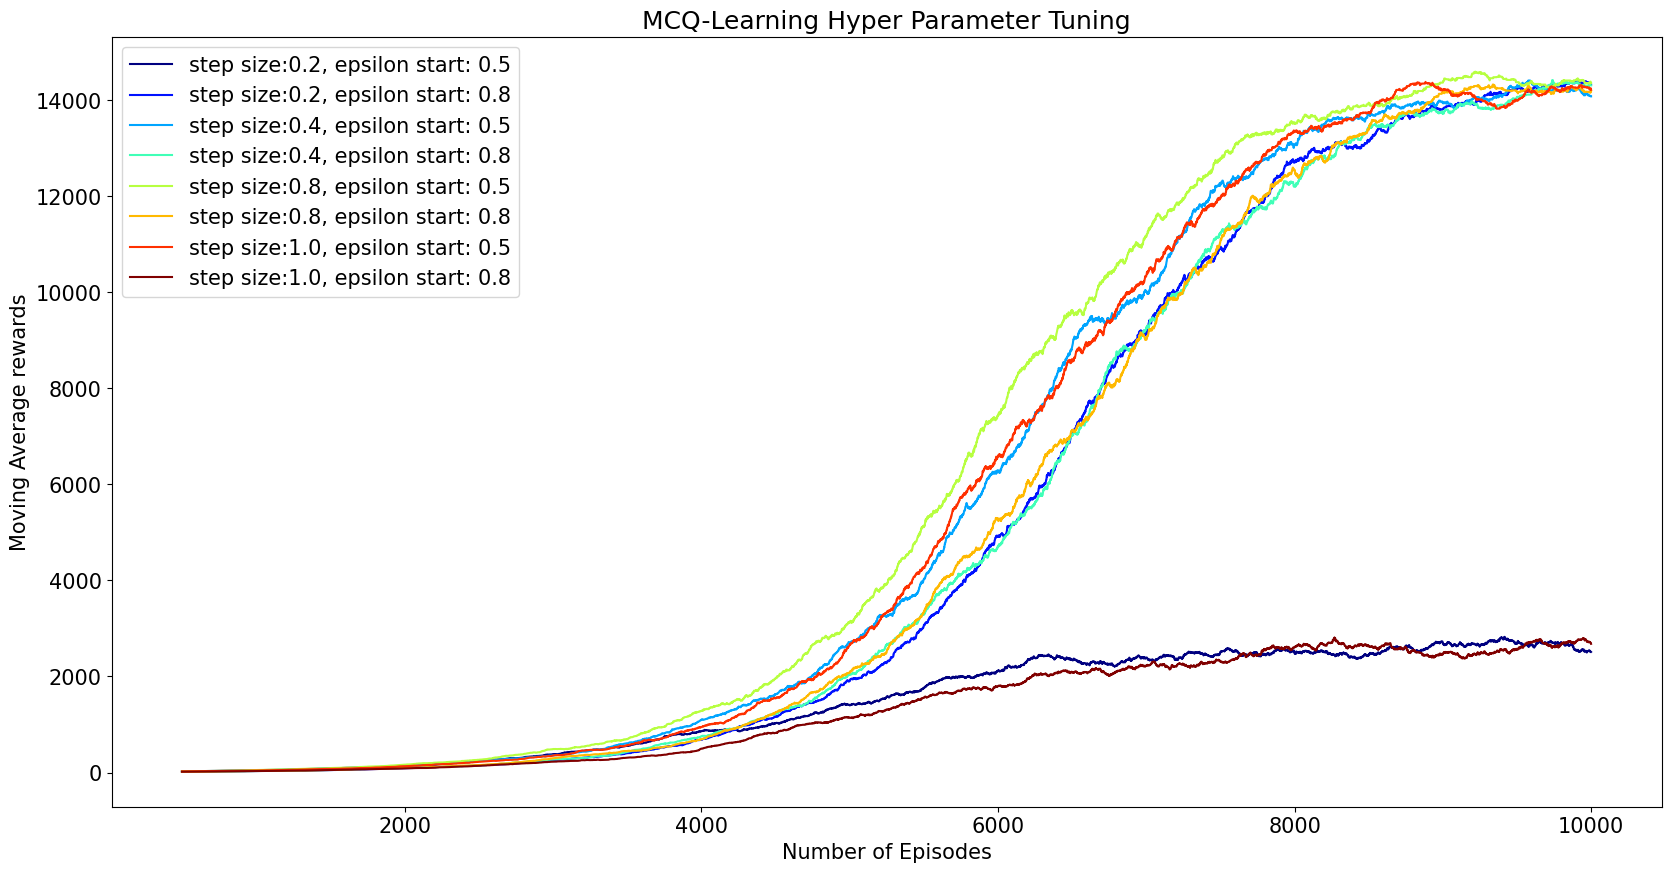

In [16]:
plot_hpt_score(MCQL_param_tuning,"rewards","MCQ-Learning",window = 60)

Hyperparameter tuning for sarsa model

In [ ]:
#Agent 2 - Expected SARSA Hyperparameter tuning
params = {"alpha": [0.2, 0.4, 0.8, 1.0], "eps_start": [0.5, 0.8]}
SARSA_scores = {}
SARSA_rewards = {}
total_trials = np.prod(np.array([len(params[key]) for key in params.keys()]))
i = 0
for alpha in params['alpha']:
    for eps_start in params['eps_start']:
        i+=1
        agent, scores_history,total_reward_history = train_agent(num_episodes = 10000,
                                                                             max_score = 1500, eps_start = eps_start,
                                                                             eps_decay = 0.999, eps_min = 1e-4,
                                                                             step_size = alpha,
                                                                             gamma = 0.95,algorithm = 'SARSA')
        SARSA_scores[(alpha,eps_start)] = scores_history
        SARSA_rewards[alpha,eps_start] = total_reward_history
        print(f"{i}/{total_trials} trials completed!")

100%|██████████| 10000/10000 [1:09:26<00:00,  2.40it/s]


1/8 trials completed!


100%|██████████| 10000/10000 [48:40<00:00,  3.42it/s]


2/8 trials completed!


100%|██████████| 10000/10000 [1:08:51<00:00,  2.42it/s]


3/8 trials completed!


100%|██████████| 10000/10000 [1:01:33<00:00,  2.71it/s]


4/8 trials completed!


100%|██████████| 10000/10000 [1:01:44<00:00,  2.70it/s]


5/8 trials completed!


100%|██████████| 10000/10000 [52:52<00:00,  3.15it/s]


6/8 trials completed!


100%|██████████| 10000/10000 [01:15<00:00, 132.50it/s]


7/8 trials completed!


100%|██████████| 10000/10000 [46:10<00:00,  3.61it/s]

8/8 trials completed!


In [ ]:
#Save hyperparameter files
models_path = '\content'
f = open(models_path + "SARSA"+"_scores_10000_gs_dict_1500_pipes.pkl","wb")
pickle.dump(SARSA_scores,f)
f.close()

f = open(models_path + "SARSA"+"_rewards_10000_gs_dict_1500_pipes.pkl","wb")
pickle.dump(SARSA_rewards,f)
f.close()

In [ ]:
#Load Hyperparameter Files
models_path = '\content'
with (open(models_path + "SARSA_scores_10000_gs_dict_1500_pipes.pkl", "rb")) as openfile:
    while True:
        try:
           SARSA_scores_10000 =  pickle.load(openfile)
        except EOFError:
            break

with (open(models_path + "SARSA_rewards_10000_gs_dict_1500_pipes.pkl", "rb")) as openfile:
    while True:
        try:
           SARSA_rewards_10000 =  pickle.load(openfile)
        except EOFError:
            break

In [ ]:
SARSA_param_tuning = {"scores":SARSA_scores_10000,"rewards":SARSA_rewards_10000}

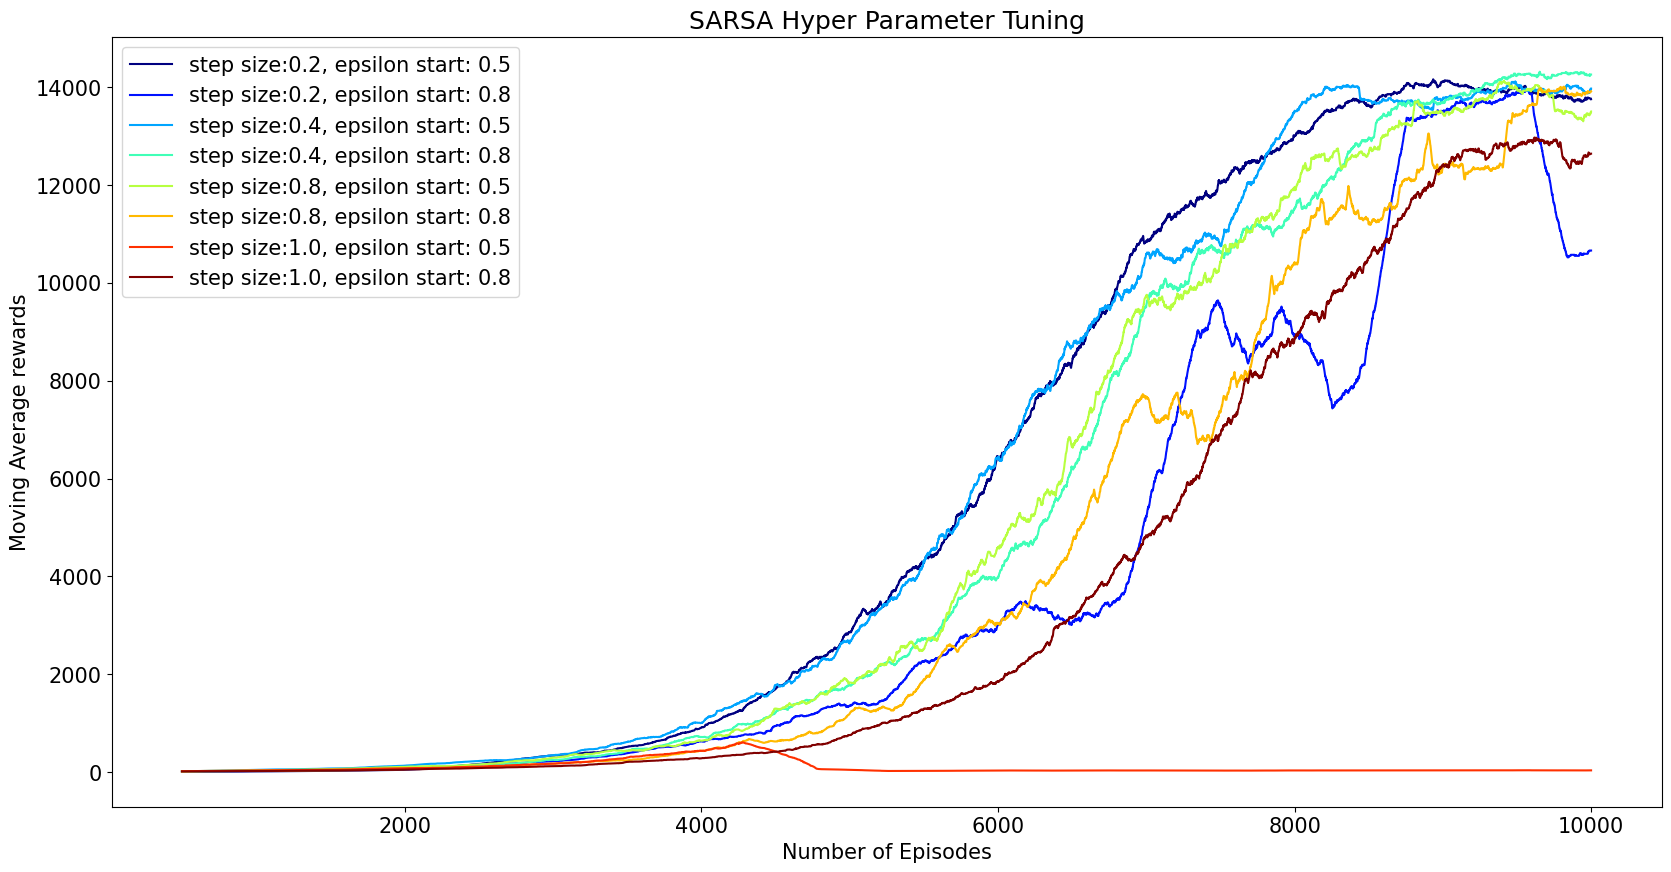

In [ ]:
plot_hpt_score(SARSA_param_tuning,"rewards","SARSA",window = 100)

Plotting the state-value function

In [ ]:
optimal_params = {"MCQL": [0.2, 0.9], "SARSA": [0.5, 0.2]}

#for algo in ['MCQL','SARSA']:
for algo in ['MCQL']:
    epsilon = optimal_params[algo][0]
    alpha = optimal_params[algo][1]

    trained_agent, scores_history,total_reward_history = train_agent(num_episodes = 10000,
                                                                             max_score = 7000, eps_start = epsilon,
                                                                             eps_decay = 0.999, eps_min = 1e-4,
                                                                            step_size = alpha, gamma = 0.95,
                                                                            algorithm = algo)

    history_dict = {"scores": scores_history,"rewards": total_reward_history}



 76%|███████▌  | 7577/10000 [1:02:50<1:02:54,  1.56s/it]

In [ ]:
    # create a binary pickle file
    f = open(algo+"_history_dict_3.pkl","wb")
    pickle.dump(history_dict,f)
    f.close()

    # create a binary pickle file
    f = open(algo+"_agent_model_3.pkl","wb")
    pickle.dump(trained_agent,f)
    f.close()
    break

Saving the states and the dictionary to use it to plot state values

In [ ]:
models_path = '\content'
with (open(models_path + "MCQL_agent_model_3.pkl", "rb")) as openfile:
    while True:
        try:
           MCQL_agent =  pickle.load(openfile)
        except EOFError:
            break

with (open(models_path + "MCQL_history_dict_3.pkl", "rb")) as openfile:
    while True:
        try:
           MCQL_history =  pickle.load(openfile)
        except EOFError:
            break

with (open(models_path + "SARSA_agent_model_3.pkl", "rb")) as openfile:
    while True:
        try:
           SARSA_agent =  pickle.load(openfile)
        except EOFError:
            break

with (open(models_path + "SARSA_history_dict_3.pkl", "rb")) as openfile:
    while True:
        try:
           SARSA_history =  pickle.load(openfile)
        except EOFError:
            break

In [ ]:
#plots the value function of a select agent
def plot_state_values(agent, agent_name):
    import numpy as np
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    def get_Z(x, y, agent):
        if (x, y) in agent.state_dict.keys():
            return np.max(agent.q[agent.state_dict[(x, y)]])
        else:
            return 0

    def get_figure(ax, agent):
        x_range = np.arange(0, 13)
        y_range = np.arange(-11, 12)
        X, Y = np.meshgrid(x_range, y_range)

        Z = np.array([get_Z(x, y, agent) for x, y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm)
        ax.set_xlabel("Player's X Distance from Pipe")
        ax.set_ylabel("Player's Y Distance from Pipe")
        ax.set_zlabel("State Value")
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(agent_name + ' State Value Plot')
    get_figure(ax, agent)


In [ ]:
# Plotting for Monte Carlo agent
plot_state_values(MCQL_agent, "MCQL")


In [ ]:
# Plotting for SARSA agent
plot_state_values(SARSA_agent,"SARSA")